This is the infer notebook.
For evaluation on training set, refer to [Getting Started Qwen2.5-32b-instruct-awq [eval]](https://www.kaggle.com/code/jiazhuang/getting-started-qwen2-5-32b-instruct-awq-eval)

In [3]:
#| default_exp core

In [4]:
#| export

import vllm

import concurrent
import io
import logging
import re
import re2

# Add
from typing import List
import random
import math
# Add end

import cairosvg
import kagglehub
import torch
from lxml import etree

# Add
import concurrent.futures
# Add end

svg_constraints = kagglehub.package_import('metric/svg-constraints')

INFO 04-23 15:27:46 [__init__.py:239] Automatically detected platform cuda.


In [5]:
#| export

# Add
logging.basicConfig(level=logging.INFO)
# Add end

# Modified
# num_attempt = 6
num_attempt = 10

class Model:
    def __init__(self):
        self.model_path = kagglehub.model_download('qwen-lm/qwen2.5/Transformers/32b-instruct-awq/1')
        
        self.llm = vllm.LLM(
            self.model_path,
            quantization="awq",
            tensor_parallel_size=2,
            gpu_memory_utilization=0.95,
            trust_remote_code=True,
            dtype="half",
            enforce_eager=True,
            max_model_len=5120,
            disable_log_stats=True
        )
        
        self.sampling_params = vllm.SamplingParams(
            n=1,  # Number of output sequences to return for each prompt.
            top_k=30,  # Float that controls the cumulative probability of the top tokens to consider.
            top_p=0.85,
            temperature=0.75,  # randomness of the sampling
            repetition_penalty=1.05,
            # seed=777, # Seed for reprodicibility
            skip_special_tokens=False,  # Whether to skip special tokens in the output.
            max_tokens=700,  # Maximum number of tokens to generate per output sequence.
        )
        
        self.tokenizer = self.llm.get_tokenizer()
        
#         self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
# <constraints>
# * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
# * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
# </constraints>

# <example>
# <description>"A lighthouse overlooking the ocean"</description>
# <thought>
# Let's do it step-by-step.
# 1. Understand the description. It involves a structure (lighthouse), a background (ocean), and a perspective (`overlooking`).
# 2. Break down the elements:
# Lighthouse: Could be represented by stacked rectangles/trapezoids for the tower, a circle/polygon for the lamp house, and maybe a triangle/cone for the roof. A simple beam of light could be a triangle or polygon.
# Ocean: Could be a simple rectangle at the bottom, maybe with some wavy lines (using paths) on top to suggest water.
# Sky: Another rectangle for the background.
# Positioning: Place the lighthouse on one side (e.g., left), perhaps on a small base representing land/rocks, with the ocean filling the rest of the lower part.
# 3. Generate and refine the SVG Code.
# </thought>
# ```svg
# <svg viewBox="0 0 300 200" width="300" height="200">
#   <rect width="100%" height="100%" fill="skyblue"/>
#   <rect x="0" y="140" width="100%" height="60" fill="#006994"/>
#   <path d="M 0 145 Q 50 135, 100 145 T 200 145 T 300 145" stroke="white" stroke-width="1.5" fill="none" opacity="0.7"/>
#   <path d="M -50 155 Q 0 145, 50 155 T 150 155 T 250 155 T 350 155" stroke="white" stroke-width="1.5" fill="none" opacity="0.7"/>
#   <path d="M10,200 L10,140 Q 50,125 90,140 L 90,200 Z" fill="dimgray" stroke="black" stroke-width="0.5"/>
#   <g id="lighthouse" transform="translate(25, 0)">
#     <polygon points="10,140 40,140 35,70 15,70" fill="white" stroke="black"/>
#     <rect x="15.8" y="115" width="18.4" height="10" fill="red"/>
#     <rect x="16.6" y="90" width="16.8" height="10" fill="red"/>
#     <rect x="10" y="65" width="30" height="5" fill="grey" stroke="black" stroke-width="0.5"/>
#     <rect x="15" y="50" width="20" height="15" fill="lightyellow" stroke="black"/>
#     <polygon points="12,50 38,50 25,35" fill="darkred" stroke="black"/>
#     <polygon points="35,57 180,110 180,130" fill="rgba(255, 255, 150, 0.6)"/>
#   </g>
# </svg>
# ```
# </example>

# Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

# <description>"{}"</description>
# <thought>
# The user wants an SVG representation of description "{}".
# I will think step-by-step about the elements and attributes needed to create this SVG based on the description and constraints.
# ... (Here the LLM should generate its step-by-step reasoning for the new description)
# </thought>
# ```svg
# <svg viewBox="0 0 256 256" width="256" height="256">
# """
#         self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
# <constraints>
# * **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
# * **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
# </constraints>

# <example>
# <description>"A lighthouse overlooking the ocean"</description>
# ```svg
# <svg viewBox="0 0 300 200" width="300" height="200">
#   <rect width="100%" height="100%" fill="skyblue"/>
#   <rect x="0" y="140" width="100%" height="60" fill="#006994"/>
#   <path d="M 0 145 Q 50 135, 100 145 T 200 145 T 300 145" stroke="white" stroke-width="1.5" fill="none" opacity="0.7"/>
#   <path d="M -50 155 Q 0 145, 50 155 T 150 155 T 250 155 T 350 155" stroke="white" stroke-width="1.5" fill="none" opacity="0.7"/>
#   <path d="M10,200 L10,140 Q 50,125 90,140 L 90,200 Z" fill="dimgray" stroke="black" stroke-width="0.5"/>
#   <g id="lighthouse" transform="translate(25, 0)">
#     <polygon points="10,140 40,140 35,70 15,70" fill="white" stroke="black"/>
#     <rect x="15.8" y="115" width="18.4" height="10" fill="red"/>
#     <rect x="16.6" y="90" width="16.8" height="10" fill="red"/>
#     <rect x="10" y="65" width="30" height="5" fill="grey" stroke="black" stroke-width="0.5"/>
#     <rect x="15" y="50" width="20" height="15" fill="lightyellow" stroke="black"/>
#     <polygon points="12,50 38,50 25,35" fill="darkred" stroke="black"/>
#     <polygon points="35,57 180,110 180,130" fill="rgba(255, 255, 150, 0.6)"/>
#   </g>
# </svg>
# ```
# </example>

# Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

# <description>"{}"</description>
# ```svg
# <svg viewBox="0 0 256 256" width="256" height="256">
# """
        self.prompt_template = """Generate a beautiful, aesthetically pleasing SVG code that visually represents the following text description, while respecting these strict constraints:
<constraints>
* **Allowed Elements:** svg, path, circle, rect, ellipse, line, polyline, polygon, g, linearGradient, radialGradient, stop, defs
* **Allowed Attributes:** viewBox, width, height, fill, stroke, stroke-width, d, cx, cy, r, x, y, rx, ry, x1, y1, x2, y2, points, transform, opacity
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
</example>

Focus on visually appealing composition, color usage, and (optionally) subtle gradients or transforms. 
Always provide **complete** SVG with nothing omitted, no ellipses.

<description>"{}"</description>
svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    def _apply_template(self, user_description: str) -> str:
        prompt = self.prompt_template.format(user_description)
        msgs = [{"role": "user", "content": prompt}]
        text = self.tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
        return text

    def _parse_svg(self, response: str) -> str:
        matchs = re.findall(r"<svg.*?</svg>", response, re.DOTALL)
        return matchs[-1].strip() if matchs else ""

    def _check_svg_valid(self, svg_code: str) -> bool:
        try:
            cairosvg.svg2png(bytestring=svg_code.encode("utf-8"))
            return True
        except:
            return False

    def _reward_function(self, svg: str) -> float:
        if not self._check_svg_valid(svg):
            return 0.0

        base_score = 1.0

        # 多様な形状 (タグ)
        shape_tags = ["circle", "rect", "ellipse", "line", "polygon", "polyline", "path"]
        used_tags = set()
        shape_count = 0
        for tag in shape_tags:
            c = len(re.findall(f"<{tag}", svg, re.IGNORECASE))
            if c > 0:
                used_tags.add(tag)
            shape_count += c
        diversity_score = len(used_tags)           # up to ~7
        shape_count_score = min(shape_count, 20)   # up to 20

        # color usage => fill= / stroke= patterns
        color_matches = re.findall(r'(?:fill|stroke)\s*=\s*"[^"]+"', svg)
        color_count = len(color_matches)
        color_score = min(color_count / 4.0, 3.0)  # 4色ごとに+1, up to 3

        # gradient or defs => big aesthetic jump
        gradient_defs_score = 0.5 if any(g in svg for g in ["<linearGradient", "<radialGradient", "<defs"]) else 0.0

        # transform => +0.3
        transform_score = 0.3 if re.search(r'transform\s*=', svg, re.IGNORECASE) else 0.0

        # stroke+fill => +0.3
        stroke_fill_score = 0.3 if ('stroke=' in svg and 'fill=' in svg) else 0.0

        # size penalty: 3000〜4000までは許容、それ以上は急激に減点
        size = len(svg.encode("utf-8"))
        if size>4000:
            size_score = 0.3
        elif size>2000:
            size_score = 0.6
        else:
            size_score = 1.0

        total = (
            base_score +
            0.5*diversity_score +
            0.4*shape_count_score +
            color_score +
            gradient_defs_score +
            transform_score +
            stroke_fill_score +
            size_score
        )
        return round(total, 4)
    
    # # You could try increasing `max_new_tokens`
    # def predict(self, description: str, max_new_tokens=512) -> str:
    #     def apply_template(prompt, tokenizer):
    #         messages = [
    #             {"role": "user", "content": prompt},
    #         ]
    #         text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    #         return text
        
    #     def parse_svg_from_response(response):
    #         matchs = re.findall(r'<svg.*?</svg>', response, re.S)
    #         if matchs:
    #             return matchs[-1].strip()
    #         else:
    #             return ''
        
    #     def check_svg_valid(svg):
    #         try:
    #             cairosvg.svg2png(bytestring=svg.encode('utf-8'))
    #             return True
    #         except:
    #             return False
        
    #     def generate_svg():
    #         try:
    #             prompt = self.prompt_template.format(description)
    #             inputs = [apply_template(prompt, self.tokenizer)] * num_attempt
    #             responses = self.llm.generate(inputs, self.sampling_params, use_tqdm=False)
    #             responses = [x.outputs[0].text for x in responses]
    #             # print('Responses: %s', responses)
    #             svgs = [parse_svg_from_response(x) for x in responses]
    #             # use the first valid svg
    #             choosen_svg = None
    #             for svg in svgs:
    #                 if check_svg_valid(svg):
    #                     svg = self.enforce_constraints(svg)
    #                     if check_svg_valid(svg):
    #                         choosen_svg = svg
    #                         break
                
    #             assert choosen_svg is not None
    #             return svg

    #         except Exception as e:
    #             logging.error('Exception during SVG generation: %s', e)
    #             # print('Exception during SVG generation: %s', e)
    #             # print(f'Exception during output generation: {e}')
    #             return self.default_svg
        
    #     return generate_svg()

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            # print(f"SVG Parse Error: {e}. Returning default SVG.")
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            # print(f"SVG could not be sanitized to meet constraints: {e}")
            return self.default_svg

    def _refine_svg(self, svg_code: str) -> str:
        refine_prompt = (
            "Here is an SVG code:\n"
            f"{svg_code}\n\n"
            "Please refine or beautify it further (e.g., add subtle gradient, transform, interesting shapes) "
            "while preserving the same main composition. Return only the complete <svg> code, no comments or ellipses."
        )
        msgs = [{"role": "user", "content": refine_prompt}]
        refine_txt = self.tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)

        resp = self.llm.generate([refine_txt], self.sampling_params, use_tqdm=False)
        if not resp:
            return svg_code
        new_svg = self._parse_svg(resp[0].outputs[0].text)
        if not new_svg:
            return svg_code

        new_svg = self.enforce_constraints(new_svg)
        if self._check_svg_valid(new_svg):
            old_sc = self._reward_function(svg_code)
            new_sc = self._reward_function(new_svg)
            if new_sc>old_sc:
                logging.info(f"Refine success: {old_sc} => {new_sc}")
                return new_svg
        return svg_code

    def train_with_rl(self, sample_prompts: List[str], search_size: int=5):
        best_params = None
        best_score = -9999.0

        cands = []
        for _ in range(search_size):
            temp = random.uniform(0.6,1.0)
            top_p = random.uniform(0.75,0.99)
            top_k = random.randint(20,70)
            cands.append((temp, top_p, top_k))

        for (temp, t_p, t_k) in cands:
            logging.info(f"Trying param => t={temp}, p={t_p}, k={t_k}")
            sp = vllm.SamplingParams(
                n=1,
                top_k=t_k,
                top_p=t_p,
                temperature=temp,
                repetition_penalty=1.05,
                skip_special_tokens=False,
                max_tokens=700
            )
            ssum = 0.0
            cc = 0
            for pr in sample_prompts:
                txt = self._apply_template(pr)
                outp = self.llm.generate([txt]*2, sp, use_tqdm=False)
                for r in outp:
                    svg_raw = self._parse_svg(r.outputs[0].text)
                    cleaned = self.enforce_constraints(svg_raw)
                    ssum += self._reward_function(cleaned)
                    cc += 1
            avg = ssum/cc if cc>0 else 0.0
            logging.info(f"Avg reward => {avg}")
            if avg>best_score:
                best_score = avg
                best_params = (temp, t_p, t_k)

        if best_params is not None:
            logging.info(f"Best found => {best_params}, score={best_score}")
            (temp, p, k) = best_params
            self.sampling_params = vllm.SamplingParams(
                n=1,
                top_k=k,
                top_p=p,
                temperature=temp,
                repetition_penalty=1.05,
                skip_special_tokens=False,
                max_tokens=700
            )

    def predict(self, description: str) -> str:
        def generate_svg():
            try:
                prompt_txt = self._apply_template(description)
                # 同一promptで複数回生成
                responses = self.llm.generate([prompt_txt]*num_attempt,
                                              self.sampling_params,
                                              use_tqdm=False)
                cands = []
                for r in responses:
                    raw_svg = self._parse_svg(r.outputs[0].text)
                    if not raw_svg:
                        continue
                    cleaned = self.enforce_constraints(raw_svg)
                    if self._check_svg_valid(cleaned):
                        cands.append(cleaned)

                if not cands:
                    logging.warning("No valid => default return")
                    return self.default_svg

                # ベスト選定
                best_svg = None
                best_sc = -9999.0
                for c in cands:
                    sc = self._reward_function(c)
                    if sc>best_sc:
                        best_sc = sc
                        best_svg = c

                # refine
                refined = self._refine_svg(best_svg)
                ref_sc = self._reward_function(refined)
                if ref_sc>best_sc:
                    return refined
                else:
                    return best_svg

            except Exception as e:
                logging.error("Exception in generate_svg: %s", e)
                return self.default_svg

        return generate_svg()

In [6]:
model = Model()

INFO 04-23 15:28:22 [config.py:689] This model supports multiple tasks: {'embed', 'classify', 'score', 'generate', 'reward'}. Defaulting to 'generate'.
WARNING 04-23 15:28:24 [config.py:768] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
WARNING 04-23 15:28:24 [arg_utils.py:1731] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 04-23 15:28:24 [config.py:1713] Defaulting to use mp for distributed inference
WARNING 04-23 15:28:24 [cuda.py:96] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 04-23 15:28:24 [llm_engine.py:243] Initializing a V0 LLM engine (v0.8.4) with config: model='/kaggle/input/qwen2.5/transformers/32b-instruct-awq/1', speculative_config=None, tokenizer='/kaggle/input/qwen2.5/transformers/32b-instruct-awq/1', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=Non

Loading safetensors checkpoint shards:   0% Completed | 0/5 [00:00<?, ?it/s]


(VllmWorkerProcess pid=170) INFO 04-23 15:32:56 [loader.py:458] Loading weights took 215.08 seconds
INFO 04-23 15:32:56 [loader.py:458] Loading weights took 215.35 seconds
(VllmWorkerProcess pid=170) INFO 04-23 15:32:56 [model_runner.py:1146] Model loading took 9.0935 GiB and 215.419012 seconds
INFO 04-23 15:32:56 [model_runner.py:1146] Model loading took 9.0935 GiB and 215.670045 seconds
(VllmWorkerProcess pid=170) INFO 04-23 15:33:13 [worker.py:267] Memory profiling takes 15.68 seconds
(VllmWorkerProcess pid=170) INFO 04-23 15:33:13 [worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.95) = 14.00GiB
(VllmWorkerProcess pid=170) INFO 04-23 15:33:13 [worker.py:267] model weights take 9.09GiB; non_torch_memory takes 0.10GiB; PyTorch activation peak memory takes 0.73GiB; the rest of the memory reserved for KV Cache is 4.08GiB.
INFO 04-23 15:33:13 [worker.py:267] Memory profiling takes 15.80 seconds
INFO 04-23 15:33:13 [worker.py:267] th

## Generate on training data

In [7]:
from IPython.display import SVG, display

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [8]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')

In [9]:
train_df.head()

,id,description
0,02d892,a purple forest at dusk
1,0dcd2e,gray wool coat with a faux fur collar
2,1e9ac1,a lighthouse overlooking the ocean
3,2b25db,burgundy corduroy pants with patch pockets and...
4,4e6a54,orange corduroy overalls


In [10]:
r = train_df.iloc[2]
r.description

'a lighthouse overlooking the ocean'

In [11]:
%%time
svg = model.predict(r.description)

CPU times: user 1min 48s, sys: 711 ms, total: 1min 49s
Wall time: 1min 50s


In [12]:
train_df['svg'] = train_df.description.progress_apply(model.predict)

  0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
train_df

,id,description,svg
0,02d892,a purple forest at dusk,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
1,0dcd2e,gray wool coat with a faux fur collar,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
2,1e9ac1,a lighthouse overlooking the ocean,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
4,4e6a54,orange corduroy overalls,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
5,4f1b00,a purple silk scarf with tassel trim,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
6,61b500,a green lagoon under a cloudy sky,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
7,65cc74,crimson rectangles forming a chaotic grid,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
8,7c4414,purple pyramids spiraling around a bronze cone,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
9,996c3a,magenta trapezoids layered on a transluscent s...,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."


In [14]:
print(train_df.iloc[3]['description'])
print(train_df.iloc[9]['description'])
print(train_df.iloc[14]['description'])

burgundy corduroy pants with patch pockets and silver buttons
magenta trapezoids layered on a transluscent silver sheet
a maroon dodecahedron interwoven with teal threads


In [15]:
for i in range(len(train_df['svg'])):
    print(train_df.iloc[i]['svg'])

<svg viewBox="0 0 256 256" width="256" height="256"><defs><linearGradient id="skyGradient" x1="0%" y1="0%" x2="0%" y2="100%"><stop offset="0%" stop-color="#87CEEB"/><stop offset="100%" stop-color="#1E90FF"/></linearGradient><linearGradient id="groundGradient" x1="0%" y1="0%" x2="0%" y2="100%"><stop offset="0%" stop-color="#483D8B"/><stop offset="100%" stop-color="#48214C"/></linearGradient></defs><rect x="0" y="0" width="256" height="256" fill="url(#skyGradient)"/><rect x="0" y="150" width="256" height="106" fill="url(#groundGradient)"/><g transform="scale(0.7) translate(40, 50)"><ellipse cx="100" cy="170" rx="30" ry="50" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><rect x="90" y="170" width="20" height="40" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><ellipse cx="180" cy="170" rx="30" ry="50" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><rect x="170" y="170" width="20" height="40" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><ellipse cx="30" cy="170" rx="30" ry="

In [16]:
train_df.to_json('train_svg.jsonl', orient='records', lines=True, force_ascii=False)

In [17]:
train_df

,id,description,svg
0,02d892,a purple forest at dusk,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
1,0dcd2e,gray wool coat with a faux fur collar,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
2,1e9ac1,a lighthouse overlooking the ocean,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
3,2b25db,burgundy corduroy pants with patch pockets and...,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
4,4e6a54,orange corduroy overalls,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
5,4f1b00,a purple silk scarf with tassel trim,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
6,61b500,a green lagoon under a cloudy sky,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
7,65cc74,crimson rectangles forming a chaotic grid,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
8,7c4414,purple pyramids spiraling around a bronze cone,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."
9,996c3a,magenta trapezoids layered on a transluscent s...,"<svg viewBox=""0 0 256 256"" width=""256"" height=..."


In [18]:
for i in range(len(train_df['svg'])):
    print(train_df.iloc[i]['svg'])

<svg viewBox="0 0 256 256" width="256" height="256"><defs><linearGradient id="skyGradient" x1="0%" y1="0%" x2="0%" y2="100%"><stop offset="0%" stop-color="#87CEEB"/><stop offset="100%" stop-color="#1E90FF"/></linearGradient><linearGradient id="groundGradient" x1="0%" y1="0%" x2="0%" y2="100%"><stop offset="0%" stop-color="#483D8B"/><stop offset="100%" stop-color="#48214C"/></linearGradient></defs><rect x="0" y="0" width="256" height="256" fill="url(#skyGradient)"/><rect x="0" y="150" width="256" height="106" fill="url(#groundGradient)"/><g transform="scale(0.7) translate(40, 50)"><ellipse cx="100" cy="170" rx="30" ry="50" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><rect x="90" y="170" width="20" height="40" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><ellipse cx="180" cy="170" rx="30" ry="50" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><rect x="170" y="170" width="20" height="40" fill="#5B2C6F" stroke="#483D8B" stroke-width="2"/><ellipse cx="30" cy="170" rx="30" ry="

## Display

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
from PIL import Image
import cairosvg

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

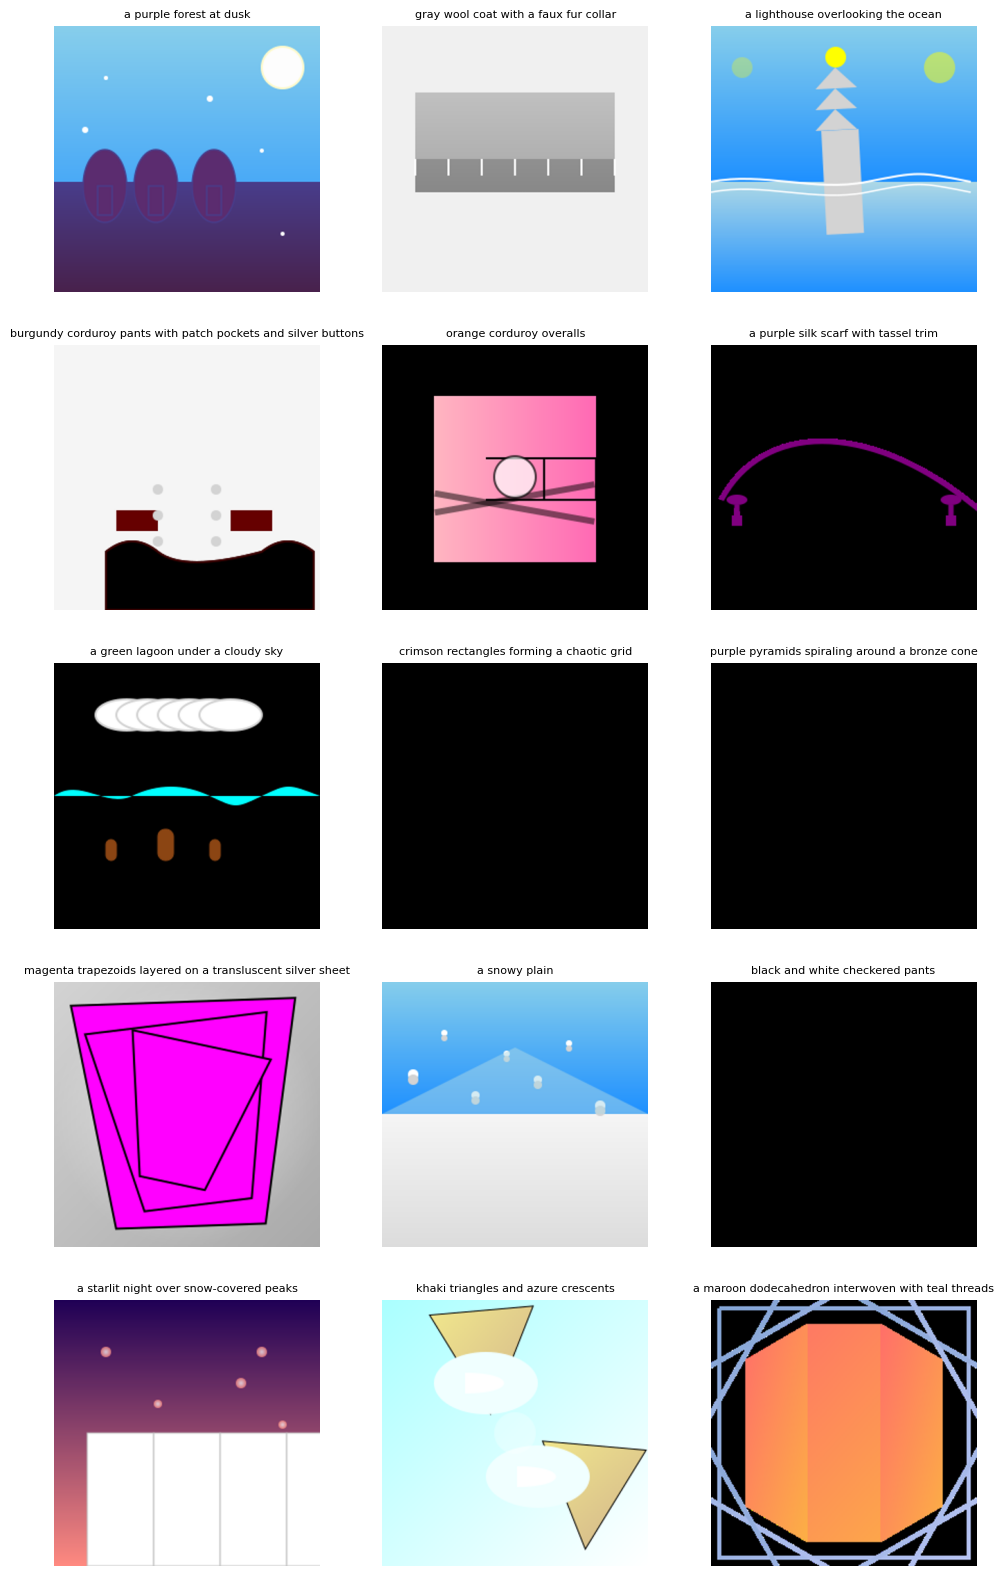

In [21]:
plt.figure(figsize=(12, 20))
for i, r in enumerate(train_df.itertuples(), 1):
    plt.subplot(5, 3, i)
    img = svg_to_png(r.svg)
    plt.imshow(img)
    plt.axis('off')
    plt.title(r.description, fontdict={'fontsize': 8})